In [1]:
import asyncio
import json
import os
import re
from datetime import datetime, timedelta
from typing import List, Optional

import isodate
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tiktoken
from langchain_google_genai import ChatGoogleGenerativeAI, GoogleGenerativeAIEmbeddings
from langchain_neo4j import Neo4jGraph
from pydantic import BaseModel, Field
from tqdm import tqdm

In [2]:
os.environ["NEO4J_URI"] = "bolt://localhost:7687"
os.environ["NEO4J_USERNAME"] = "neo4j"
os.environ["NEO4J_PASSWORD"] = "password"

graph = Neo4jGraph(refresh_schema=False)

In [3]:
import getpass

if not os.environ.get("GOOGLE_API_KEY"):
    os.environ["GOOGLE_API_KEY"] = getpass.getpass("GOOGLE_KEY")

GOOGLE_KEY ········


In [4]:
def read_txt_files(folder_path):
    data = []
    
    # Ensure the folder exists
    if not os.path.exists(folder_path):
        raise FileNotFoundError(f"Folder '{folder_path}' not found. Please download the CUAD dataset"
                               " at https://www.atticusprojectai.org/cuad"
                               )
    
    for filename in os.listdir(folder_path):
        if filename.endswith(".txt"):
            file_id = os.path.splitext(filename)[0]  # Extract filename without extension
            file_path = os.path.join(folder_path, filename)
            
            with open(file_path, "r", encoding="utf-8") as file:
                text = file.read()
                data.append({"file_id": file_id, "text": text})
    
    return data

In [5]:
contracts = read_txt_files("full_contract_txt")

In [6]:
def num_tokens_from_string(string: str, encoding_name: str = "cl100k_base") -> int:
    """Returns the number of tokens in a text string."""
    encoding = tiktoken.get_encoding(encoding_name)
    num_tokens = len(encoding.encode(string))
    return num_tokens

In [7]:
token_count = [num_tokens_from_string(el['text']) for el in contracts]

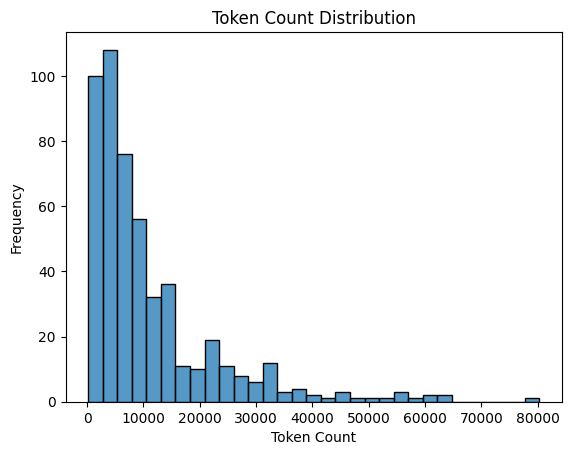

In [8]:
sns.histplot(token_count)  
plt.title("Token Count Distribution")  
plt.xlabel("Token Count")  
plt.ylabel("Frequency")  
plt.show()

In [9]:
class Location(BaseModel):
    """
    Represents a physical location including address, city, state, and country.
    """

    address: Optional[str] = Field(
        ..., description="The street address of the location.Use None if not provided"
    )
    city: Optional[str] = Field(
        ..., description="The city of the location.Use None if not provided"
    )
    state: Optional[str] = Field(
        ..., description="The state or region of the location.Use None if not provided"
    )
    country: str = Field(
        ...,
        description="The country of the location. Use the two-letter ISO standard.",
    )


class Organization(BaseModel):
    """
    Represents an organization, including its name and location.
    """

    name: str = Field(..., description="The name of the organization.")
    location: Location = Field(
        ..., description="The primary location of the organization."
    )
    role: str = Field(
        ...,
        description="The role of the organization in the contract, such as 'provider', 'client', 'supplier', etc.",
    )


contract_types = [
    "Affiliate Agreement" "Development",
    "Distributor",
    "Endorsement",
    "Franchise",
    "Hosting",
    "IP",
    "Joint Venture",
    "License Agreement",
    "Maintenance",
    "Manufacturing",
    "Marketing",
    "Non Compete/Solicit" "Outsourcing",
    "Promotion",
    "Reseller",
    "Service",
    "Sponsorship",
    "Strategic Alliance",
    "Supply",
    "Transportation",
]


class Contract(BaseModel):
    """
    Represents the key details of the contract.
    """

    summary: str = Field(
        ...,
        description="High level summary of the contract with relevant facts and details. Include all relevant information to provide full picture.",
    )
    contract_type: str = Field(
        ...,
        description="The type of contract being entered into.",
        enum=contract_types,
    )
    parties: List[Organization] = Field(
        ...,
        description="List of parties involved in the contract, with details of each party's role.",
    )
    effective_date: str = Field(
        ...,
        description=(
            "Enter the date when the contract becomes effective in yyyy-MM-dd format."
            "If only the year (e.g., 2015) is known, use 2015-01-01 as the default date."
            "Always fill in full date"
        ),
    )
    contract_scope: str = Field(
        ...,
        description="Description of the scope of the contract, including rights, duties, and any limitations.",
    )
    renewal_term: Optional[str] = Field(
        None,
        description="Terms of renewal",
    )
    term: Optional[str] = Field(
        None,
        description=(
            "The duration of the agreement, including provisions for renewal or termination."
            "Use ISO 8601 durations standard"
        ),
    )

    end_date: Optional[str] = Field(
        None,
        description=(
            "The date when the contract expires. Use yyyy-MM-dd format."
            "If only the year (e.g., 2015) is known, use 2015-01-01 as the default date."
            "Always fill in full date"
        ),
    )
    total_amount: Optional[float] = Field(
        None, description="Total value of the contract."
    )
    governing_law: Optional[Location] = Field(
        None, description="The jurisdiction's laws governing the contract."
    )


In [10]:
llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash")
llm.with_structured_output(Contract).invoke(
    "Write me a ballad about LangChain"
)

Contract(summary='This is a ballad about LangChain', contract_type='IP', parties=[Organization(name='Bard', location=Location(address='unknown', city='unknown', state='unknown', country='US'), role='author')], effective_date='2024-01-01', contract_scope='This is a ballad about LangChain', renewal_term=None, term=None, end_date=None, total_amount=None, governing_law=None)

In [11]:
embeddings = GoogleGenerativeAIEmbeddings(model="models/text-embedding-004")
vector = await embeddings.aembed_query("hello, world!")
vector[:5]

[0.014134909026324749,
 -0.022324152290821075,
 -0.054603420197963715,
 -0.006284549366682768,
 -0.03392402455210686]

In [12]:
def is_valid_date(date_string):
    try:
        datetime.strptime(date_string, '%Y-%m-%d')
        return True
    except:
        return False

def add_duration_to_date(date_str, duration_str):
    """
    Add an ISO 8601 duration to a date string.
    
    Args:
        date_str (str): Date in format 'YYYY-MM-DD'
        duration_str (str): Duration in ISO 8601 format (e.g., 'P1Y2M3DT4H5M6S')
    
    Returns:
        str: Resulting date in format 'YYYY-MM-DD'
    
    Examples:
        >>> add_duration_to_date('2023-01-15', 'P1Y')
        '2024-01-15'
        >>> add_duration_to_date('2023-01-15', 'P1M')
        '2023-02-15'
        >>> add_duration_to_date('2023-01-15', 'P10D')
        '2023-01-25'
    """
    # Parse the date string
    date_obj = datetime.strptime(date_str, "%Y-%m-%d")
    
    # Parse the duration string using isodate
    duration = isodate.parse_duration(duration_str)
    
    # Add the duration to the date
    result_date = date_obj + duration
    
    # Format the result as 'YYYY-MM-DD'
    return result_date.strftime("%Y-%m-%d")

async def process_contract(contract, semaphore):
    async with semaphore:  # This controls access to the resource
        structured_data = await llm.with_structured_output(Contract).ainvoke(contract["text"])
        try:
            structured_data = json.loads(structured_data.model_dump_json())
        except: # When LLM breaks
            return {"file_id": contract["file_id"]}
        structured_data["file_id"] = contract["file_id"]
        # Clean dates
        structured_data["effective_date"] = structured_data["effective_date"] if is_valid_date(structured_data["effective_date"]) else None
        structured_data["end_date"] = structured_data["end_date"] if is_valid_date(structured_data["end_date"]) else None

        # Infer end date
        if not structured_data["end_date"] and (structured_data["effective_date"] and structured_data["term"]):
            try:
                structured_data["end_date"] = add_duration_to_date(structured_data["effective_date"], structured_data["term"])
            except:
                pass
        return structured_data

async def process_all(contracts, max_workers=10):
    # Create a semaphore with the desired number of workers
    semaphore = asyncio.Semaphore(max_workers)
    
    # Create tasks with the semaphore
    tasks = [process_contract(contract, semaphore) for contract in contracts]
    
    # Use tqdm with asyncio.as_completed to show progress
    results = []
    for future in tqdm(asyncio.as_completed(tasks), total=len(tasks), desc="Processing contracts"):
        result = await future
        results.append(result)
    
    return results

In [13]:
results = await process_all(contracts)
results[0]

Processing contracts: 100%|██████████| 510/510 [01:53<00:00,  4.51it/s]


{'summary': 'This Collaborative Development and Commercialization Agreement is for the development and commercialization of a therapeutic drug monitoring assay for the measurement of concentrations of Plazomicin in biological fluids.',
 'contract_type': 'Joint Venture',
 'parties': [{'name': 'Microgenics Corporation',
   'location': {'address': '46500 Kato Road',
    'city': 'Fremont',
    'state': 'California',
    'country': 'US'},
   'role': 'provider'},
  {'name': 'Achaogen Inc.',
   'location': {'address': '7000 Shoreline Court, #371',
    'city': 'South San Francisco',
    'state': 'California',
    'country': 'US'},
   'role': 'client'}],
 'effective_date': '2016-04-26',
 'contract_scope': 'Collaborative development and commercialization of a therapeutic drug monitoring assay for the measurement of concentrations of Plazomicin in biological fluids.',
 'renewal_term': None,
 'term': None,
 'end_date': None,
 'total_amount': None,
 'governing_law': None,
 'file_id': 'Microgenics C

In [14]:
with open("contract_data.json", "w") as json_file:
    json.dump(results, json_file, indent=4)

In [15]:
graph.query("CREATE CONSTRAINT IF NOT EXISTS FOR (c:Contract) REQUIRE c.file_id IS UNIQUE;")
graph.query("CREATE CONSTRAINT IF NOT EXISTS FOR (c:Party) REQUIRE c.name IS UNIQUE;")

[]

In [16]:
query = """UNWIND $data AS row
MERGE (c:Contract {file_id: row.file_id})
SET c.summary = row.summary,
    c.contract_type = row.contract_type,
    c.effective_date = date(row.effective_date),
    c.contract_scope = row.contract_scope,
    c.renewal_term = row.renewal_term,
    c.term = row.term,
    c.end_date = CASE WHEN row.end_date IS NOT NULL THEN date(row.end_date) ELSE NULL END,
    c.total_amount = row.total_amount,
    c.governing_law = row.governing_law.country

FOREACH (party IN row.parties |
    MERGE (p:Party {name: party.name})
    MERGE (l:Country {name: party.location.country})
    MERGE (p)-[:LOCATED_IN]->(l)
    MERGE (p)-[pr:PARTY_TO]->(c)
    SET pr.role = party.role
)
"""

In [17]:
graph.query(query, {"data": results})

[]

In [18]:
embeddings_output = await embeddings.aembed_documents([el["summary"] for el in results])

params = []
for embedding, contract in zip(embeddings_output,results):
    params.append({"file_id": contract["file_id"], "embedding": embedding})

with open("contract_embedding.json", "w") as json_file:
    json.dump(params, json_file, indent=4)

graph.query("""UNWIND $data AS row
MATCH (c:Contract {file_id:row.file_id})
CALL db.create.setNodeVectorProperty(c, 'embedding', row.embedding)""", 
            {"data": params})

[]

In [19]:
graph.query("CREATE VECTOR INDEX contractSummary IF NOT EXISTS FOR (c:Contract) ON c.embedding")

[]